In [1]:
import uproot
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
import os
import textwrap

In [4]:
path = "/vols/hyperk/users/kj4718/clarence/results/wcsim_wcte_CDS_pgun_e-_1000_analysed_wcsimrootevent.root"
infile = uproot.open(path)

#infile["validation_per_event;4"].keys()
infile["validation_per_trigger;1"].keys()
# infile["validation_per_file;1"].keys()

['eventnumber',
 'triggernumber',
 'triggertype',
 'ndigihits',
 'ntubeshitdigi',
 'ndigihitstrigger',
 'triggertime',
 'digipeperdigi',
 'digitimeperdigi',
 'totaldigipe',
 'totaldiginoisefrac',
 'digipe',
 'digitime',
 'digitime_noise',
 'digitime_photon',
 'digitime_mix',
 'digiplustriggertime',
 'diginoisefrac']

In [5]:
# Define the directory containing the ROOT files
filenames = "/vols/hyperk/users/kj4718/clarence/results"
full_paths = sorted([os.path.join(filenames, file) for file in os.listdir(filenames) if file.endswith(".root")])
events = 1
#Combine all events into a single array for each branch
per_event = uproot.concatenate(
    {tuple(full_paths[0:events]): "validation_per_event;4"}, 
    ["track_energy", 
     "track_startpos", "track_dir",
     "track_flag", "track_parentid",
     "nrawhits", "hittime", "hittime_photon", "hittime_noise"])
per_trigger = uproot.concatenate(
    {tuple(full_paths[0:events]): "validation_per_trigger;1"},
    ['ndigihits', 'totaldigipe', 'digitime', 'digitime_photon', 'digitime_noise', 'digitime_photon', 'digitime_mix'])

per_file = uproot.concatenate(
    {tuple(full_paths[0:events]): "validation_per_file;1"},
    ['npmt20', 'npmtm', 'npmtod', 'WCCylRadius', 'WCCylLength'])

In [6]:
#Direction
directions = per_event["track_dir"]
dir_x = directions["fX"]
dir_y = directions["fY"]
dir_z = directions["fZ"]

#Positions
start_pos = per_event["track_startpos"]
pos_x = start_pos["fX"]
pos_y = start_pos["fY"]
pos_z = start_pos["fZ"]

#Energy
energy = per_event["track_energy"]

#For cuts
flag = per_event["track_flag"]
parentid = per_event["track_parentid"]
cut = (parentid == 0) & (flag >= 0)

#Apply the cut
cut_dir_x = dir_x[cut]
cut_dir_y = dir_y[cut]
cut_dir_z = dir_z[cut]
cut_pos_x = pos_x[cut]
cut_pos_y = pos_y[cut]
cut_pos_z = pos_z[cut]
cut_pos_r = np.sqrt(cut_pos_x**2 + cut_pos_z**2)
cut_e = energy[cut]

# Flatten the arrays
cut_dir_x_flat = ak.flatten(cut_dir_x, axis=None)
cut_dir_y_flat = ak.flatten(cut_dir_y, axis=None)   
cut_dir_z_flat = ak.flatten(cut_dir_z, axis=None)
cut_x_flat = ak.flatten(cut_pos_x, axis=None)
cut_y_flat = ak.flatten(cut_pos_y, axis=None)
cut_z_flat = ak.flatten(cut_pos_z, axis=None)
cut_e_flat = ak.flatten(cut_e, axis=None)

In [7]:
#Digitised hits
hits = ak.flatten(per_trigger["ndigihits"], axis=None)

#Sum of charge of digitised hits
total_charge = ak.flatten(per_trigger["totaldigipe"], axis=None)

#Time of each digit
digitime = ak.flatten(per_trigger["digitime"], axis=None)

#Digits that are made of purely true “physics” hits (e.g. cherenkov photons), purely dark noise “hits”, and a mix of physics/dark hits
digit_photon = ak.flatten(per_trigger["digitime_photon"], axis=None)
digit_noise = ak.flatten(per_trigger["digitime_noise"], axis=None)
mix = ak.flatten(per_trigger["digitime_mix"], axis=None)

#Raw hits before PMT and electronics simulations (per event rather than per trigger)
raw = ak.flatten(per_event["nrawhits"], axis=None)

#All/physics/dark hits
hittime = ak.flatten(per_event["hittime"], axis=None)
hittime_photon = ak.flatten(per_event["hittime_photon"], axis=None)
hittime_noise = ak.flatten(per_event["hittime_noise"], axis=None)


In [9]:
no_pmts_20 = per_file["npmt20"]
no_pmts_m = per_file["npmtm"]
no_pmts_od = per_file["npmtod"]
radius = per_file["WCCylRadius"]
length = per_file["WCCylLength"]

In [10]:
azimuth = np.arctan2(cut_dir_y_flat, cut_dir_z_flat)

In [11]:
# Function to apply ROOT-like styling
def apply_root_style():
    plt.style.use("default")  # Reset to default style
    plt.rcParams.update({
        "font.family": "serif",  # Use serif font like ROOT
        "font.size": 14,         # Increase font size
        "axes.labelsize": 16,    # Axis label size
        "axes.titlesize": 18,    # Title size
        "xtick.labelsize": 14,   # X-axis tick size
        "ytick.labelsize": 14,   # Y-axis tick size
        "grid.color": "gray",    # Grid color
        "grid.linestyle": "--",  # Dashed grid lines
        "grid.linewidth": 0.5,   # Grid line width
        "axes.grid": True,       # Enable grid
        "axes.edgecolor": "black",  # Axis edge color
        "axes.linewidth": 1.2,      # Axis line width
        "legend.fontsize": 12,      # Legend font size
        "legend.frameon": False,    # Remove legend frame
    })

# Function to plot histograms with wrapped legends
def plot_histogram(data, xlabel, title, range=None, log=False):
    apply_root_style()  # Apply ROOT-like styling
    num_entries = len(data)
    mean = np.mean(ak.to_numpy(data))
    std = np.std(ak.to_numpy(data)) / np.sqrt(num_entries)
    legend_text = f"Entries = {num_entries}, Mean = {mean:.2f}, Std = {std:.2f}"
    wrapped_legend = "\n".join(textwrap.wrap(legend_text, width=20))  # Wrap text to 20 characters per line

    plt.hist(data, bins=50, histtype="step", color="blue", linewidth=1.5, label=wrapped_legend, range=range)  # ROOT-like step histogram
    if log:
        plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

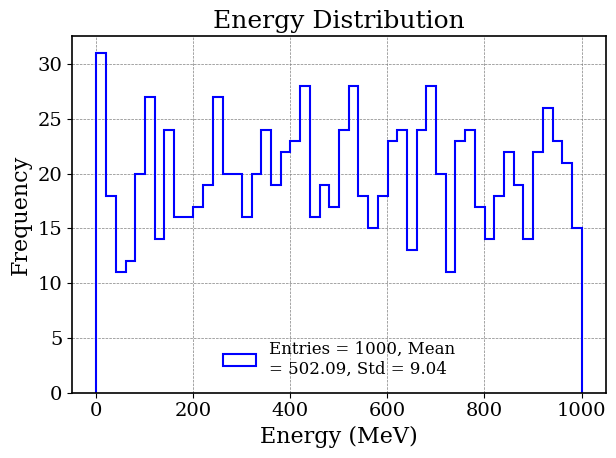

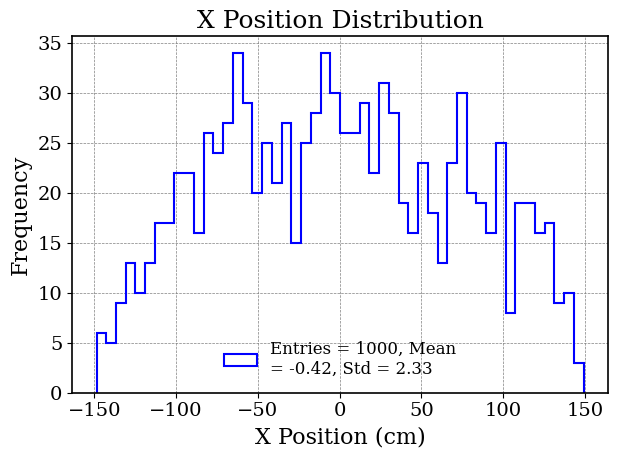

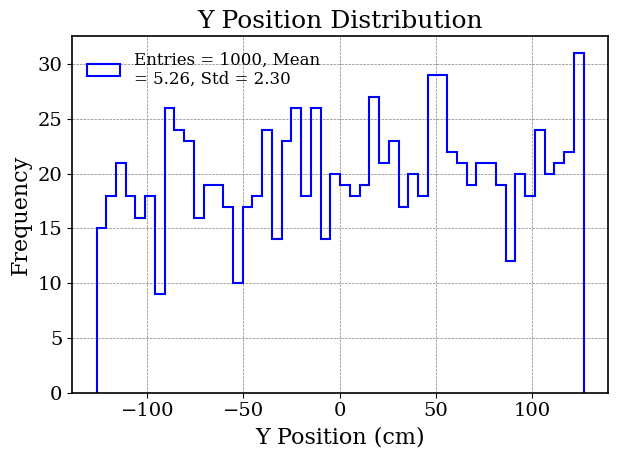

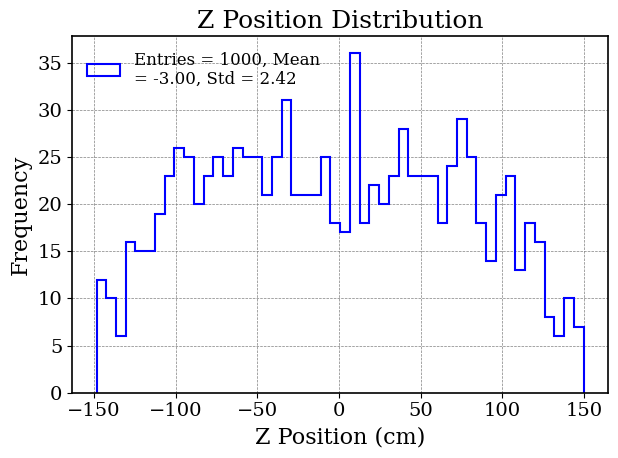

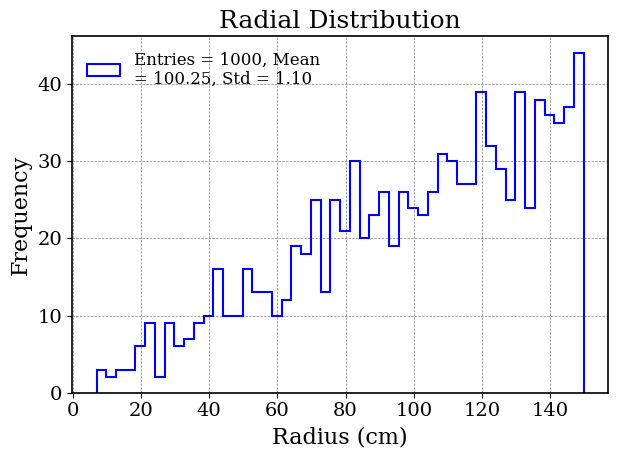

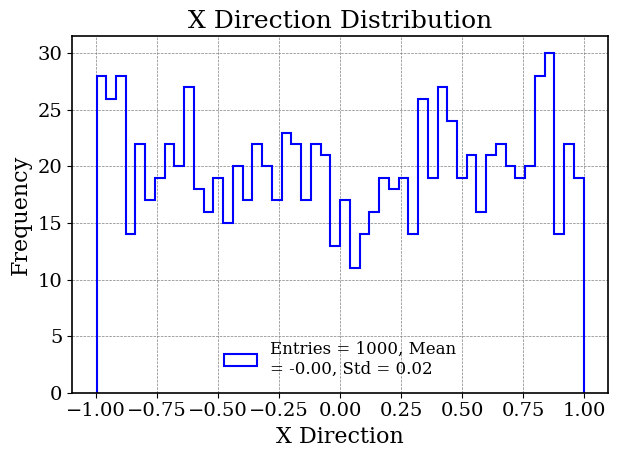

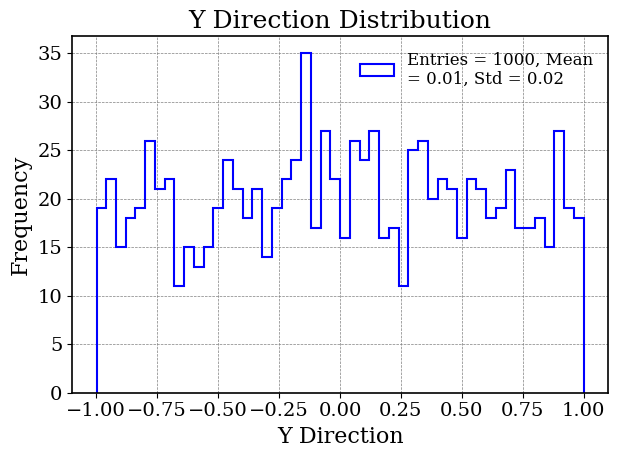

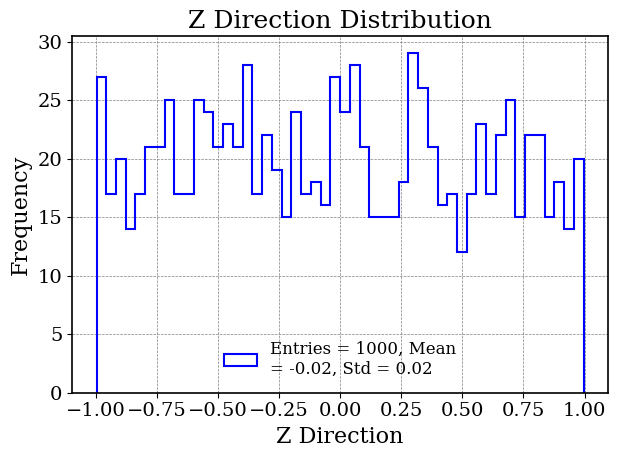

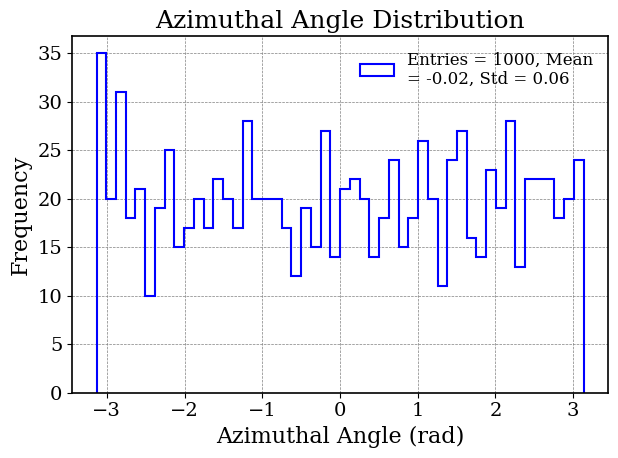

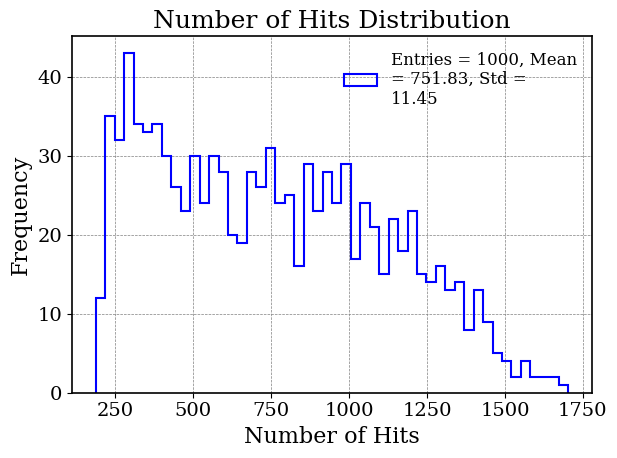

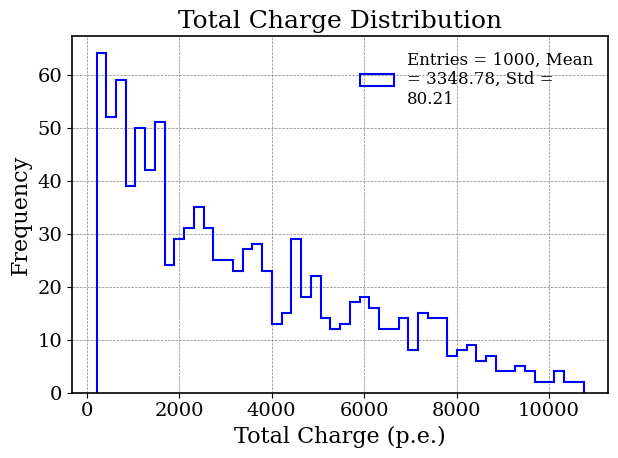

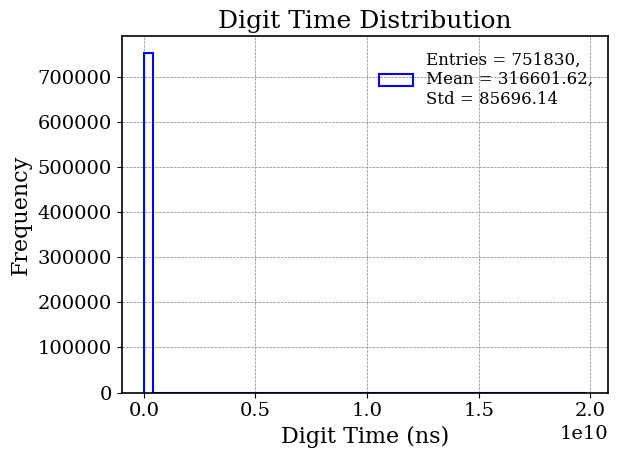

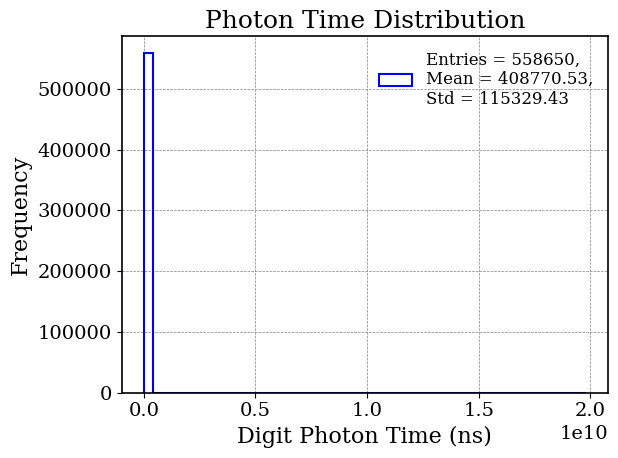

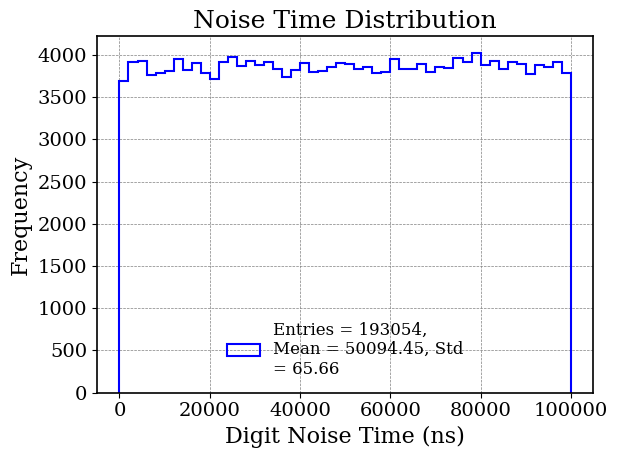

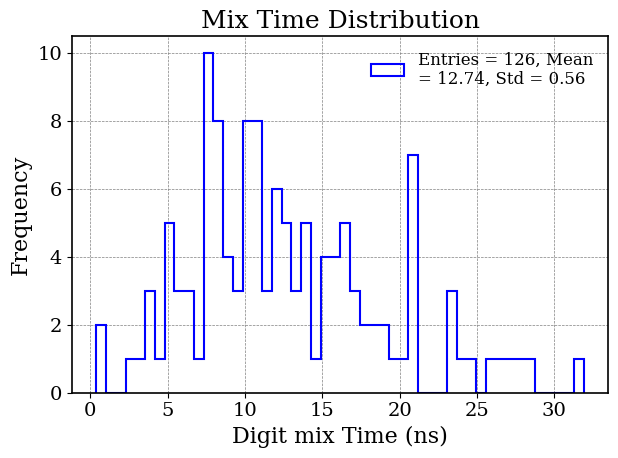

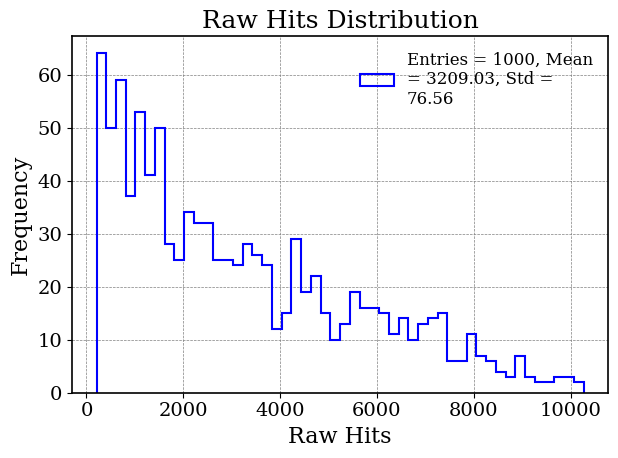

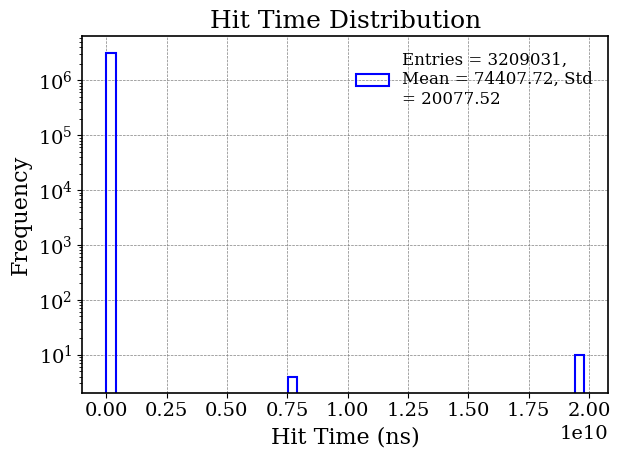

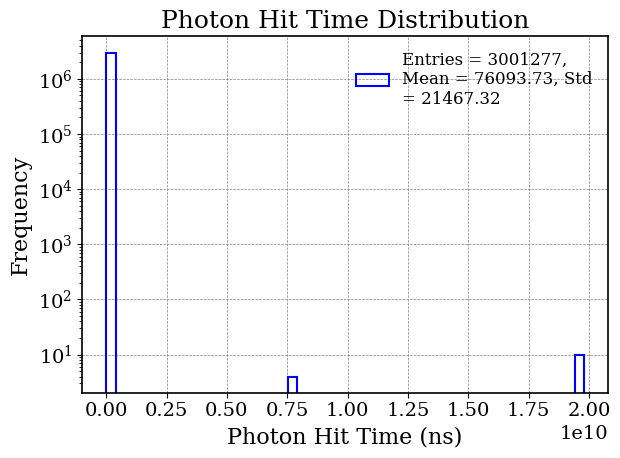

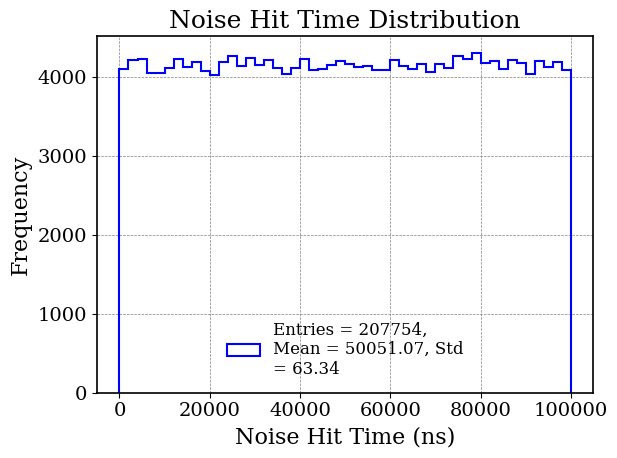

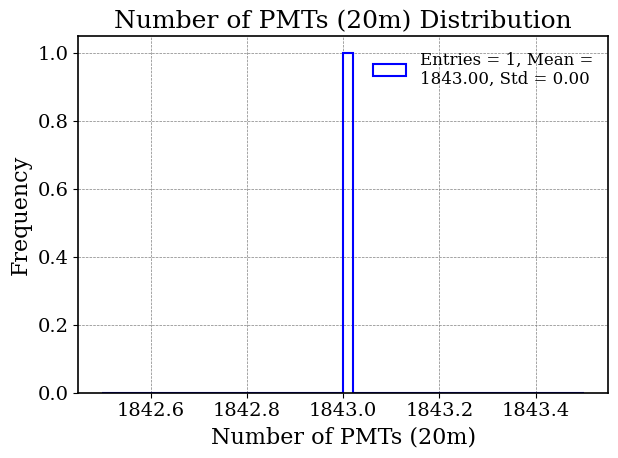

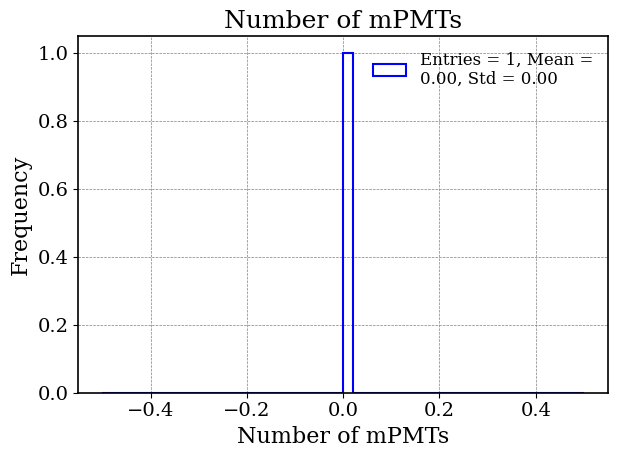

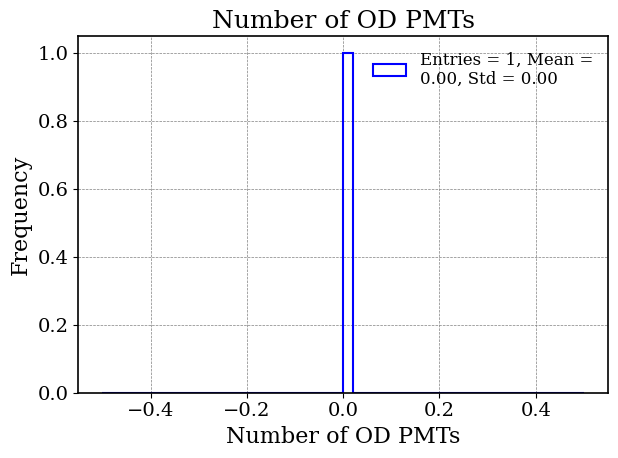

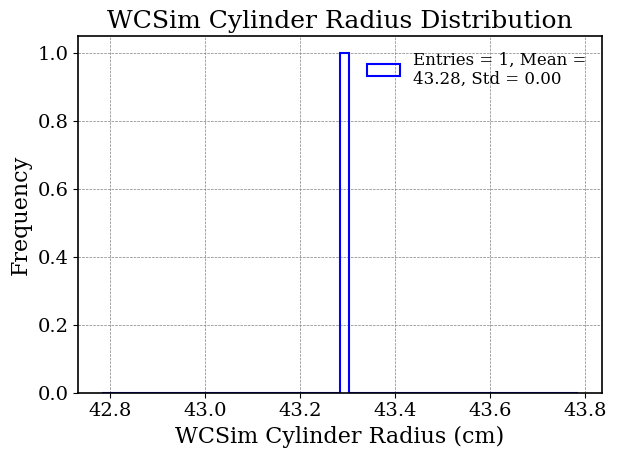

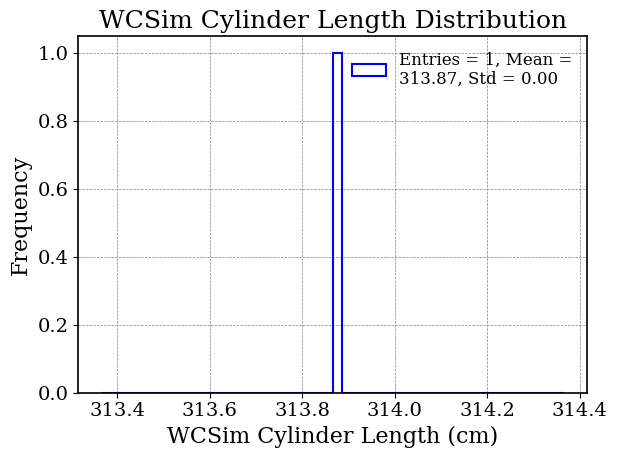

In [12]:
# Plot histograms for energy, x, y, and z
plot_histogram(cut_e_flat, "Energy (MeV)", "Energy Distribution")

plot_histogram(cut_x_flat, "X Position (cm)", "X Position Distribution")
plot_histogram(cut_y_flat, "Y Position (cm)", "Y Position Distribution") 
plot_histogram(cut_z_flat, "Z Position (cm)", "Z Position Distribution")
plot_histogram(cut_pos_r, "Radius (cm)", "Radial Distribution")

plot_histogram(cut_dir_x_flat, "X Direction", "X Direction Distribution")
plot_histogram(cut_dir_y_flat, "Y Direction", "Y Direction Distribution")
plot_histogram(cut_dir_z_flat, "Z Direction", "Z Direction Distribution")
plot_histogram(azimuth, "Azimuthal Angle (rad)", "Azimuthal Angle Distribution")

plot_histogram(hits, "Number of Hits", "Number of Hits Distribution")
plot_histogram(total_charge, "Total Charge (p.e.)", "Total Charge Distribution")

plot_histogram(digitime, "Digit Time (ns)", "Digit Time Distribution")
plot_histogram(digit_photon, "Digit Photon Time (ns)", "Photon Time Distribution",)
plot_histogram(digit_noise, "Digit Noise Time (ns)", "Noise Time Distribution")

plot_histogram(mix, "Digit mix Time (ns)", "Mix Time Distribution")
plot_histogram(raw, "Raw Hits", "Raw Hits Distribution")

plot_histogram(hittime, "Hit Time (ns)", "Hit Time Distribution", log=True)
plot_histogram(hittime_photon, "Photon Hit Time (ns)", "Photon Hit Time Distribution", log=True)
plot_histogram(hittime_noise, "Noise Hit Time (ns)", "Noise Hit Time Distribution")

plot_histogram(no_pmts_20, "Number of PMTs (20m)", "Number of PMTs (20m) Distribution")
plot_histogram(no_pmts_m, "Number of mPMTs",  "Number of mPMTs") 
plot_histogram(no_pmts_od, "Number of OD PMTs", "Number of OD PMTs")
plot_histogram(radius, "WCSim Cylinder Radius (cm)", "WCSim Cylinder Radius Distribution")
plot_histogram(length, "WCSim Cylinder Length (cm)", "WCSim Cylinder Length Distribution")

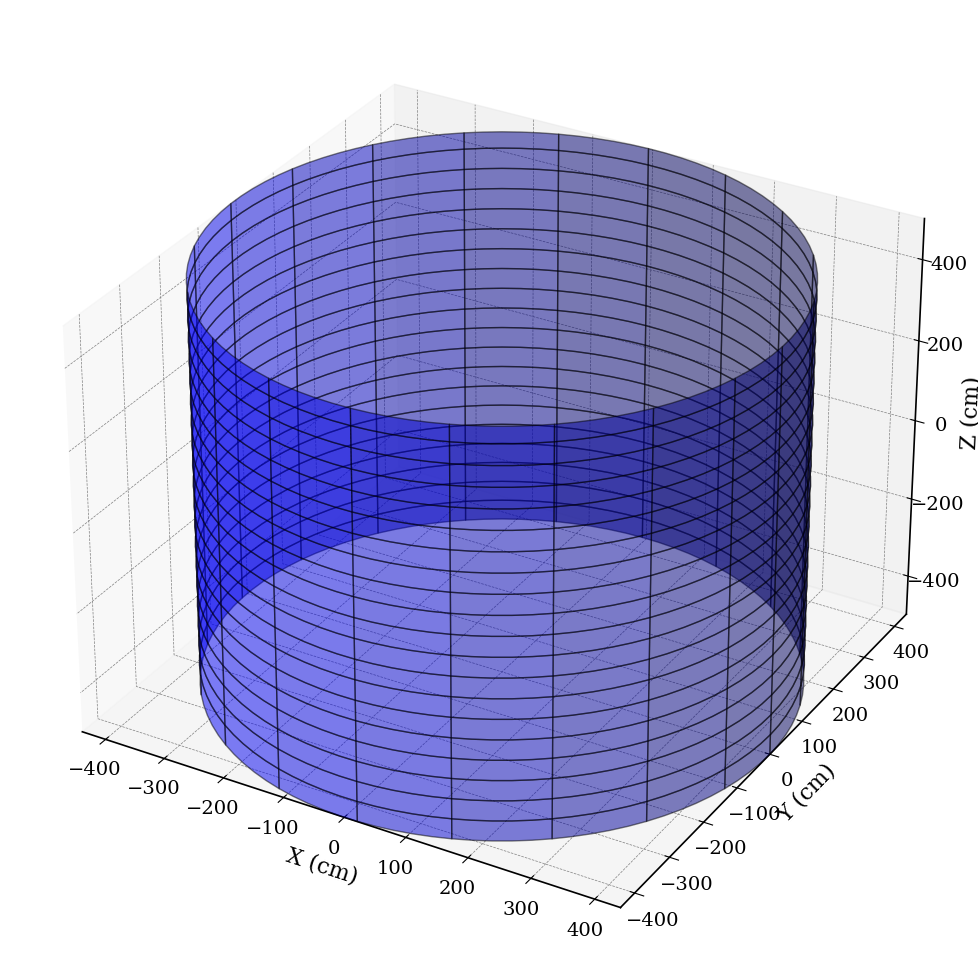

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting module

# Define cylinder parameters
cylinder_height = 1000
cylinder_radius = 440

# Generate data for the cylinder
z_cylinder = np.linspace(-cylinder_height / 2, cylinder_height / 2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
theta_grid, z_grid = np.meshgrid(theta, z_cylinder)
x_cylinder = cylinder_radius * np.cos(theta_grid)
y_cylinder = cylinder_radius * np.sin(theta_grid)

# Plot the cylinder
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_cylinder, y_cylinder, z_grid, alpha=0.5, rstride=5, cstride=5, color='blue', edgecolor='k')

# Set axis labels and limits
ax.set_xlabel('X (cm)', fontsize=16)
ax.set_ylabel('Y (cm)', fontsize=16)
ax.set_zlabel('Z (cm)', fontsize=16)
ax.set_xlim(-cylinder_radius, cylinder_radius)
ax.set_ylim(-cylinder_radius, cylinder_radius)
ax.set_zlim(-cylinder_height / 2, cylinder_height / 2)
plt.tight_layout()

plt.show()

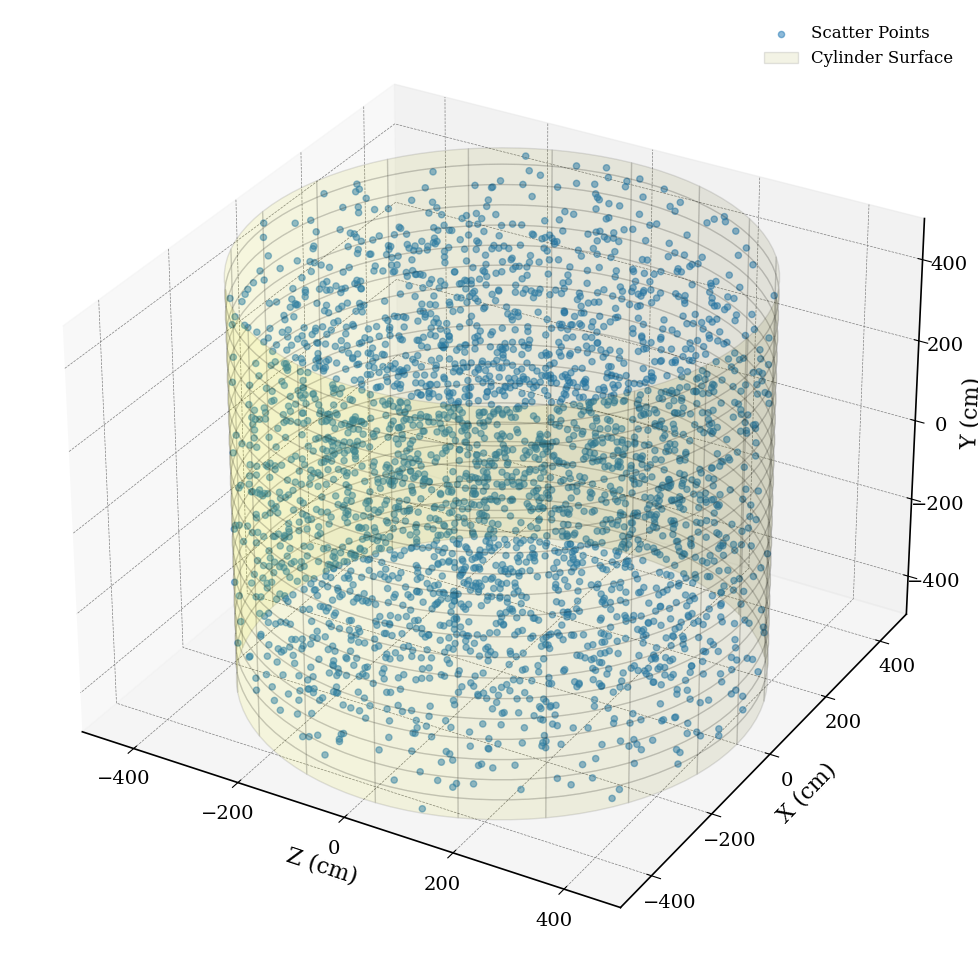

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
ax.scatter(cut_z_flat[0:3000], cut_x_flat[0:3000], cut_y_flat[0:3000], alpha=0.5, label="Scatter Points")

# Plot the cylinder
ax.plot_surface(x_cylinder, y_cylinder, z_grid, alpha=0.1, rstride=5, cstride=5, color='yellow', edgecolor='k', label="Cylinder Surface")
# Set axis labels and limits
ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)
ax.set_zlim(-500, 500)
ax.set_xlabel('Z (cm)', fontsize=16)
ax.set_ylabel('X (cm)', fontsize=16)
ax.set_zlabel('Y (cm)', fontsize=16)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


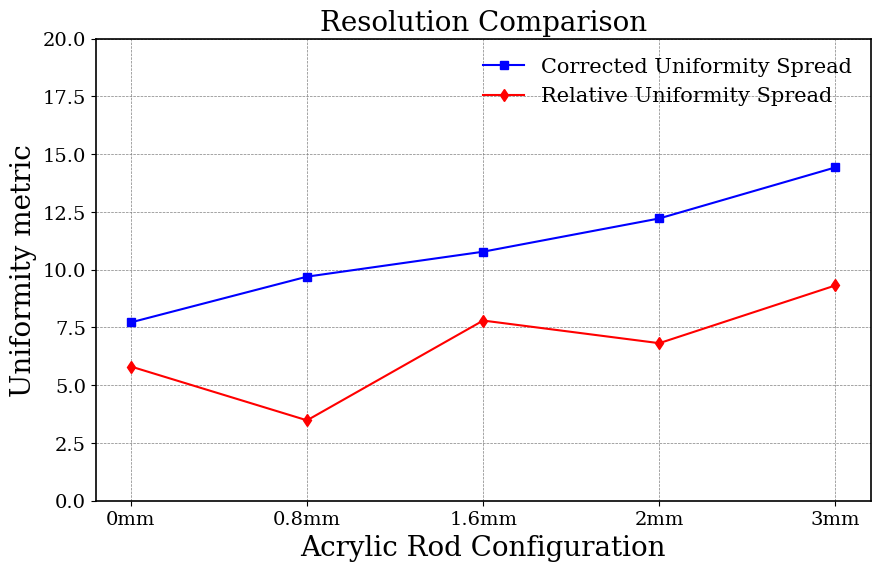

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Apply ROOT-like styling
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",  # Use serif font like ROOT
    "font.size": 14,         # Increase font size
    "axes.labelsize": 16,    # Axis label size
    "axes.titlesize": 18,    # Title size
    "xtick.labelsize": 14,   # X-axis tick size
    "ytick.labelsize": 14,   # Y-axis tick size
    "grid.color": "gray",    # Grid color
    "grid.linestyle": "--",  # Dashed grid lines
    "grid.linewidth": 0.5,   # Grid line width
    "axes.grid": True,       # Enable grid
    "axes.edgecolor": "black",  # Axis edge color
    "axes.linewidth": 1.2,      # Axis line width
    "legend.fontsize": 12,      # Legend font size
    "legend.frameon": False,    # Remove legend frame
})

uncorr_res = [10.42, 11.96, 13.35, 13.84, 13.90]
corr_res = [7.72, 9.70, 10.78, 12.22, 14.43]
rel_res = [5.81, 3.48, 7.80, 6.82, 9.32]
v_res = [9.80, 12.69, 11.62, 12.22, 18.31]
x_labels = ['0mm', '0.8mm', '1.6mm', '2mm', '3mm']
x = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(10, 6))

#ax.plot(x, uncorr_res, 'o-', label='Uncorrected Uniformity Spread')
ax.plot(x, corr_res, 's-', label='Corrected Uniformity Spread', color='blue')
ax.plot(x, rel_res, 'd-', label='Relative Uniformity Spread', color='red')
#ax.plot(x, v_res, 'd-', label='Uniformity rel to V spread')

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Acrylic Rod Configuration', size=20)
ax.set_ylabel('Uniformity metric', size=20)
ax.legend(prop={'size': 15})
ax.set_title('Resolution Comparison', size=20)
ax.set_ylim(0,20)
plt.savefig("resolution_comparison.pdf") 
plt.show()
